In [1]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split
import subprocess
import datetime 
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms.functional as F
import cv2

In [2]:
IMAGE_SIZE_WIDTH = 96
IMAGE_SIZE_HEIGHT = 96

In [3]:
def create_folder(path: str):
    subprocess.run("mkdir -p " + path, shell=True, check=True)

In [4]:
df_dample_submissions = pd.read_csv("data/SampleSubmission.csv")
df_id_lookup_table = pd.read_csv("data/IdLookupTable.csv")
df_train = pd.read_csv("data/training.csv")
df_test = pd.read_csv("data/test.csv")

## Explore tables

explore tables

In [5]:
df_dample_submissions

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27119,27120,0
27120,27121,0
27121,27122,0
27122,27123,0


In [6]:
df_id_lookup_table

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
...,...,...,...,...
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN


In [7]:
df_train

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,...,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447,254 254 254 254 254 238 193 145 121 118 119 10...


In [8]:
df_test

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
...,...,...
1778,1779,101 101 101 100 100 97 97 98 102 149 214 206 1...
1779,1780,201 191 171 158 145 140 136 130 123 115 108 10...
1780,1781,28 28 29 30 31 32 33 34 39 44 46 46 49 54 61 7...
1781,1782,104 95 71 57 46 52 65 70 70 67 76 72 69 69 72 ...


Show some image and prepare functions for visualizing 

In [9]:
def split(a, n):
    """Split a into n evenly sized chunks"""
    k, m = len(a) // n, len(a) % n
    return [a[i * k:(i + 1) * k] for i in range(n)]


def get_image(encoded_image: str):
    """get image from encoded string"""
    img_arr = list(map(lambda x: int(x), encoded_image.split(' ')))
    img_arr = np.array(split(img_arr, IMAGE_SIZE_WIDTH))

    img = Image.new("L", (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH))
    pixels = img.load()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            pixels[j, i] = int(img_arr[i][j])
    return img


def check_length(encoded_image: str):
    """checks if encoded image has valid dimensions"""
    assert encoded_image.count(' ') == IMAGE_SIZE_HEIGHT * \
        IMAGE_SIZE_WIDTH - 1, "image size don't equal expected size"


def draw_points(img, points, color=(255, 0, 0)):
    """returns image with added points"""
    rgb_img = img.convert('RGB')

    d = ImageDraw.Draw(rgb_img)
    for point in points:
        if np.isnan(point[0]):
            continue

        horizontal_line = [(int(point[0]) - 2, int(point[1])),
                           (int(point[0]) + 2, int(point[1]))]
        vertical_line = [(int(point[0]), int(point[1]) - 2),
                         (int(point[0]), int(point[1]) + 2)]
        d.line(horizontal_line, color)
        d.line(vertical_line, color)

    return rgb_img


def draw_training_record(record):
    """draws facial keypoints to image from dataset record and shows it. parametr record is row from pandas table"""
    points = []
    b = None
    for r in record.to_list()[:-1]:
        if b:
            points.append((b, r))
            b = None
        else:
            b = r

    img = get_image(record.to_list()[-1])
    img_points = draw_points(img, points)

    display(img_points)
    return img_points


def draw_predicted_target(img_arr, prediction, target):
    """Returns image and facial keypoints predicted and corect ones"""
    # create image to PIL class
    img = Image.new("L", (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH))
    pixels = img.load()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            pixels[j, i] = int(img_arr[i][j])

    # draw points to image
    img = draw_points(img, target)
    img = draw_points(img, prediction, color=(0, 0, 255))

    return img

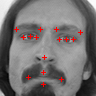

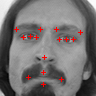

In [10]:
record = df_train.iloc[0]
draw_training_record(record)

Check if lengths of an images are as expected

In [11]:
for i, img in df_train.iterrows():
    check_length(img["Image"])

for i, img in df_test.iterrows():
    check_length(img["Image"])

In [12]:
df_train.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [13]:
df_train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

## Image preprocessing

First define some helper functions including applying CLAHE histogram equalization.

In [14]:
def apply_clahe(img_arr):
    clahe = cv2.createCLAHE(clipLimit = 3)
    final_img = clahe.apply(np.array(img_arr).astype(np.uint8))
    return final_img

def encode_image(img_arr):
    return " ".join(np.array(img_arr).astype(str).flatten())

def decode_image(img_str):
    return np.array(img_str.split(' ')).astype(int).reshape(IMAGE_SIZE_WIDTH, IMAGE_SIZE_HEIGHT)

try out some image processing.

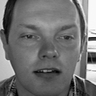

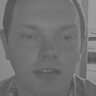

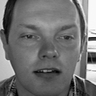

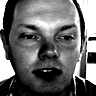

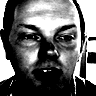

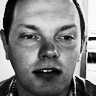

   QT_AUTO_SCREEN_SCALE_FACTOR to enable platform plugin controlled per-screen factors.
   QT_SCREEN_SCALE_FACTORS to set per-screen DPI.
   QT_SCALE_FACTOR to set the application global scale factor.


In [15]:
img_arr = decode_image(df_train.iloc[522,30])
img = Image.new("L", (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH))
pixels = img.load()
for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[j, i] = int(img_arr[i][j])

# adjust the contrast of the image
img_03_contrast = F.adjust_contrast(img, 0.3)
img_1_contrast = F.adjust_contrast(img, 1)
img_3_contrast = F.adjust_contrast(img, 3)
img_6_contrast = F.adjust_contrast(img, 6)

# display the contrast adjusted image
display(img)
display(img_03_contrast)
display(img_1_contrast)
display(img_3_contrast)
display(img_6_contrast)

img_norm = F.equalize(img)
display(img_norm)

clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize=(8,8))
final_img = clahe.apply(np.array(img_arr).astype(np.uint8))
cv2.imshow("clahe", final_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

CLAHE seems to have best results. Let's adjust all images in *df_train*.

In [16]:
images_str = df_train.Image
clahe_images_str = []

for img_str in images_str:
    clahe_images_str.append(encode_image(apply_clahe(decode_image(img_str))))

df_train["Image"] = clahe_images_str

For *df_test* as well.

In [17]:
images_str = df_test.Image
clahe_images_str = []

for img_str in images_str:
    clahe_images_str.append(encode_image(apply_clahe(decode_image(img_str))))

df_test["Image"] = clahe_images_str

## Data Augmentation

Dataset contains small fully labeled record so I will add verticaly flipped images and double the dataset.

In [18]:
def encoded_images_to_2darray(encoded_images):
    """decodes image from string to 2d array of integers"""
    images = []
    for e_i in encoded_images:
        e_i = list(map(lambda x: int(x), e_i.split(' ')))
        d_i = split(e_i, IMAGE_SIZE_WIDTH)
        images.append(d_i)
    return images

def switch_vertically(df):
  new_df = df.copy()

  # # flip images vertically
  img_arr = encoded_images_to_2darray(df.Image.tolist())
  flipped_arr = np.flip(img_arr, axis=2).astype(str)
  encoded_arr = [" ".join([" ".join(r) for r in img]) for img in flipped_arr]

  for i, r in df.iterrows():
    keypoints = r.values.tolist()[0:-1]
    switched_arr = [(f if i%2 == 1 else IMAGE_SIZE_WIDTH/2 - (f - IMAGE_SIZE_WIDTH/2 + 1) ) for i, f in enumerate(keypoints)]
    switched_arr.append(encoded_arr[i])
    
    # switch sites
    new_record = switched_arr.copy()
    new_record[0] ,new_record[2] = switched_arr[2], switched_arr[0]
    new_record[1] ,new_record[3] = switched_arr[3], switched_arr[1]
    new_record[4] ,new_record[8] = switched_arr[8], switched_arr[4]
    new_record[5] ,new_record[9] = switched_arr[9], switched_arr[5]
    new_record[6] ,new_record[10] = switched_arr[10], switched_arr[6]
    new_record[7] ,new_record[11] = switched_arr[11], switched_arr[7]
    new_record[12] ,new_record[16] = switched_arr[16], switched_arr[12]
    new_record[13] ,new_record[17] = switched_arr[17], switched_arr[13]
    new_record[14] ,new_record[18] = switched_arr[18], switched_arr[14]
    new_record[15] ,new_record[19] = switched_arr[19], switched_arr[15]
    new_record[22] ,new_record[24] = switched_arr[24], switched_arr[22]
    new_record[23] ,new_record[25] = switched_arr[25], switched_arr[23]

    new_df.iloc[i] = new_record

  return new_df

Now let's create augmented data

/tmp/ipykernel_52848/3542175422.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aug_train = df_aug_train.append(df_train)


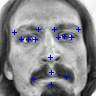

In [19]:
# create vertically flipped augmented data + append them to original ones
df_aug_train = switch_vertically(df_train)
df_aug_train = df_aug_train.append(df_train)

# display example of flipped image
img = draw_predicted_target(encoded_images_to_2darray([df_aug_train.iloc[0].values.tolist()[30]])[0],
                      list(zip(df_aug_train.iloc[0].values.tolist()[0:-1:2], df_aug_train.iloc[0].values.tolist()[1:-1:2])),
                      [])
display(img)

Now data are double size


In [20]:
df_aug_train.shape

(14098, 31)

## Prepare data

In [21]:
# declare batch size
BATCH_SIZE = 256
# declare which dataset will be used 
df_dataset = df_aug_train
# -----------------------------------

# get non null values of trainin dataset
df_train_data = df_dataset[~df_dataset.isnull().any(axis=1)]
X = df_train_data["Image"].values.tolist()
y = np.array(df_train_data.iloc[:, df_train.columns != "Image"])

# split to train and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, train_size=0.7)

# save temporary data
X_train = np.array(encoded_images_to_2darray(X_train))
X_validation = np.array(encoded_images_to_2darray(X_validation))
y_train = np.array(y_train).astype(int) # list(map(lambda x: int(x), y_train)),
y_validation = np.array(y_validation).astype(int) # list(map(lambda x: int(x), y_validation))


dataset_train = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
dataset_validation = TensorDataset(torch.Tensor(X_validation), torch.Tensor(y_validation))

dataloader_train = DataLoader(dataset_train, BATCH_SIZE)
dataloader_validation = DataLoader(dataset_validation, BATCH_SIZE)

In [22]:
print("Train dataset size:", X_train.shape[0])
print("Validation dataset size:", X_validation.shape[0])

Train dataset size: 2996
Validation dataset size: 1284


## PyTorch DL architecures

create CNN architecture

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128*12*12, 30)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.relu(self.linear(x))

        return x

create ResNet architecture

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        # out += residual
        out = out.clone() + residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, out_features = 30):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=3)
        self.fc = nn.Linear(512*3*3, out_features)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

define training function

In [25]:
def train_single_epoch(model, train_dataloader, loss_fn, optimiser, device, validation_dataloader):
    # TRAIN LOSS + BACKPROPAGATION
    train_loss = 0
    num_batches = 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        X = torch.unsqueeze(X, dim=1)

        # calculate loss
        prediction = model(X)
        _loss = loss_fn(prediction, y)
        train_loss += _loss.item()
        
        # reset gradient
        optimiser.zero_grad()
        
        # backporpagation
        _loss.backward()
        
        # update parameters
        optimiser.step()
        
        num_batches += 1
    train_loss = train_loss / num_batches
    print(f"train loss: {train_loss}")

    # VALIDATION LOSS
    validation_loss = 0
    num_batches = 0
    for X, y in validation_dataloader:
        X, y = X.to(device), y.to(device)

        X = torch.unsqueeze(X, dim=1)

        # calculate loss
        prediction = model(X)
        validation_loss += loss_fn(prediction, y).item()
        
        num_batches += 1
    validation_loss = validation_loss / num_batches
    print(f"validation loss: {validation_loss}")
    
    return (train_loss, validation_loss)
    
def train(model, train_dataloader, loss_fn, optimiser, device, epochs, validation_dataloader):
    loss_history = []
    for i in range(epochs):
        print(f"Epoch {i + 1}")
        loss = train_single_epoch(model, train_dataloader, loss_fn, optimiser, device, validation_dataloader)
        print("--------------------------")
        loss_history.append(loss)
    print("==========================")
    print("Training done")
    
    return loss_history

define predictions

In [26]:
def predict(model, x):
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        predictions = model(x)
        predicted_point = predictions[0]
        
    return predicted_point

define function for ploting loss history

In [27]:
def plot_line_graph(data,  legend=['train', 'validation'], y_scale_type='log'):
    # summarize history for model loss
    for g in data:      
      plt.plot(g)
  
    plt.title('model loss')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(legend, loc='upper left')
    plt.yscale(y_scale_type)
    plt.show()

define function for saving model

In [28]:
def save_model(model, model_description=""):
    # prepare folder for models
    folder_path = "models/"
    model_name = model.__class__.__name__ + datetime.datetime.now().strftime("%y:%m:%d:%H:%M:%S") + model_description
    create_folder(folder_path)

    # save model
    file_path = folder_path + "/" + model_name + ".pth"
    torch.save(model.state_dict(), file_path)
        
    # save loss history
    file_content = "\n".join(list(map(lambda x: x[0] + " " + x[1], np.array(loss_history).astype(str))))
    file_path = folder_path + "/" + "loss_history_" + model_name + ".txt"
    with open(file_path, "w") as f:
        f.write(file_content)

define function for adding dropout

In [29]:
def append_dropout(model, rate=0.2):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=True))
            setattr(model, name, new)

## Train models

Let's train model

In [30]:
LEARNING_RATE = 0.01
EPOCHS = 200
model_description = "w_missing_relu"
#################### TRAIN MODEL ########################

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}", "\n")

print("=======================================")
print("TRAINING")
print("=======================================")
# model = CNN().to(device)
model = ResNet(ResidualBlock, [3,4,6,3]).to(device)
# model = ResNet(ResidualBlock, [3,3,3,3]).to(device)
# model = ResNet(ResidualBlock, [2,2,2,2]).to(device)
# model = ResNet18(1, ResBlock, outputs=30).to(device)
# append_dropout(model)

loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# train model
loss_history = train(model, dataloader_train, loss_fn, optimiser, device, EPOCHS, dataloader_validation)

# plot graph
plot_line_graph(list(map(list, zip(*loss_history))))

# save model
save_model(model, model_description)


Using cpu 

TRAINING
Epoch 1
train loss: 578.5993734995524
validation loss: 94.47935740152995
--------------------------
Epoch 2
train loss: 45.006576220194496
validation loss: 26.321322441101074
--------------------------
Epoch 3
train loss: 19.46758286158244
validation loss: 14.174842834472656
--------------------------
Epoch 4
train loss: 13.313027938206991
validation loss: 11.97612714767456
--------------------------
Epoch 5
train loss: 10.774020512898764
validation loss: 10.224736213684082
--------------------------
Epoch 6
train loss: 10.186775048573812
validation loss: 10.119597911834717
--------------------------
Epoch 7
train loss: 9.920160373051962
validation loss: 9.951008637746176
--------------------------
Epoch 8
train loss: 9.861344257990519
validation loss: 9.938390254974365
--------------------------
Epoch 9
train loss: 9.791121482849121
validation loss: 9.885334332784018
--------------------------
Epoch 10
train loss: 9.755685408910116
validation loss: 9.8760714530944

KeyboardInterrupt: 

get some random prediction on validation dataset. Red is target and blue is prediction.

In [ ]:
idx = 5
# ----------------------
validation = next(iter(dataloader_train))
image = validation[0][idx]
target = validation[1][idx]
prediction = predict(model, torch.Tensor(np.expand_dims(np.expand_dims(image, axis=0), axis=0))).to("cpu")

image = image.numpy()
target = target.tolist()
prediction = prediction.tolist()
target = list(map(list, zip(target[::2], target[1::2])))
prediction = list(map(list, zip(prediction[::2], prediction[1::2])))

display(draw_predicted_target(image, prediction, target))


## Predict Test Dataset

In [ ]:
df_test

In [ ]:
df_id_lookup_table

In [ ]:
df_dample_submissions

In [ ]:
df_id_lookup_table[df_id_lookup_table["ImageId"] == 1]

In [ ]:
df_submission = df_dample_submissions.copy()

def get_feature_by_name(feature_name, features_list, columns):
  idx = columns.index(feature_name)
  return features_list[idx]

predictions = []
for idx, row in df_test.iterrows():
  # predict keypoints

  img_tensor = torch.Tensor(np.expand_dims(np.expand_dims(encoded_images_to_2darray([row["Image"]])[0], axis=0), axis=0))
  prediction = predict(model, img_tensor).to("cpu").tolist()
  predictions.append(prediction)

for idx, row in df_id_lookup_table.iterrows():
  # get value
  feature_name = row["FeatureName"]
  prediction = predictions[row["ImageId"] - 1]
  value = int(get_feature_by_name(feature_name, prediction, df_train.columns[:-1].tolist()))
  
  # save to submission
  df_submission.iloc[idx, 1] = value

df_submission

In [ ]:
a = df_submission.Location.values
df_submission.Location = np.where(a > 96, 96, a)

In [ ]:
df_submission.to_csv("models/submission" + datetime.datetime.now().strftime("%y:%m:%d:%H:%M:%S") + ".csv", index=False)

## Analysis

In [ ]:
folder_path = "/content/drive/MyDrive/FIT/NI/MVI/semestralka/models/"
files = [
    # "loss_history_ResNet22:12:28:14:11:26.txt", 
        #  "loss_history_ResNet22:12:28:13:02:21.txt",
        #  "loss_history_ResNet22:12:27:22:37:07.txt",
        #  "loss_history_ResNet22:12:27:22:24:30.txt",
        #  "loss_history_ResNet22:12:27:20:50:43.txt",
        #  "loss_history_ResNet22:12:26:23:07:59.txt",
#          "loss_history_CNN22:12:28:18:19:54.txt",
#          "loss_history_CNN22:12:28:18:24:41.txt",
#          "loss_history_CNN22:12:28:18:33:23.txt", 
#          "loss_history_CNN22:12:28:18:47:06.txt"
         ]
legend = [
#     "CNN - augm + CLAHE",
#     "CNN - nothing",
#     "CNN - CLAHE",
#     "CNN - augm"
          ]
train_loss = []
validation_loss = []

for file in files:
  with open(folder_path + file, "r") as f:
    content = f.read()
    values = np.array(content.replace('\n', ' ').split(' ')).astype(float)
    train_loss.append(values[::2])
    validation_loss.append(values[1::2])


plot_line_graph(validation_loss, legend)